In [1]:
%matplotlib inline
import torch as tc
import tensorflow as tf
import mxnet as mx
from mxnet import np as mxnp
from mxnet import npx as npx
npx.set_np()
# import numpy as np

from d2l import mxnet as mxd2l  # Use MXNet as the backend
from d2l import torch as tcd2l  # Use PyTorch as the backend
from d2l import tensorflow as tfd2l  # Use TensorFlow as the backend

tc.__version__,tf.__version__,mx.__version__

('1.6.0', '2.3.1', '1.7.0')

## MXNET

In [3]:
from mxnet.gluon import nn

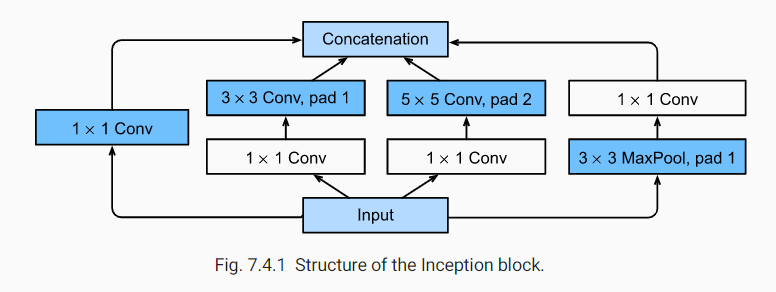

In [4]:
class InceptionMX(nn.Block):
    def __init__(self,c1:int,c2:tuple,c3:tuple,c4:int,**kwargs):
        super().__init__(**kwargs)
        #path1
        self.p1=nn.Conv2D(c1,kernel_size=1,activation='relu')
        #path2
        self.p2_l1=nn.Conv2D(c2[0],kernel_size=1,activation='relu')
        self.p2_l2=nn.Conv2D(c2[1],kernel_size=3,padding=1,activation='relu')
        #path3
        self.p3_l1=nn.Conv2D(c3[0],kernel_size=1,activation='relu')
        self.p3_l2=nn.Conv2D(c3[1],kernel_size=5,padding=2,activation='relu')
        #path3
        self.p4_l1=nn.MaxPool2D(pool_size=3,strides=1,padding=1)
        self.p4_l2=nn.Conv2D(c4,kernel_size=1,activation='relu')
        
    def forward(self,X):
        y1=self.p1(X)
        y2=self.p2_l2(self.p2_l1(X))
        y3=self.p3_l2(self.p3_l1(X))
        y4=self.p4_l2(self.p4_l1(X))
        
        y=mxnp.concatenate((y1,y2,y3,y4),axis=1) #along channels
        return y
    
b1=nn.Sequential()
b1.add(nn.Conv2D(64,kernel_size=7,strides=2,padding=3,activation='relu'),
      nn.MaxPool2D(pool_size=3,strides=2,padding=1)
      )
b2=nn.Sequential()
b2.add(nn.Conv2D(64,kernel_size=1,activation='relu'),
       nn.Conv2D(192,kernel_size=3,padding=1,activation='relu'),
       nn.MaxPool2D(pool_size=3,strides=2,padding=1))

b3=nn.Sequential()
b3.add(InceptionMX(64, (96, 128), (16, 32), 32),
       InceptionMX(128, (128, 192), (32, 96), 64),
       nn.MaxPool2D(pool_size=3,strides=2,padding=1))
b4=nn.Sequential()
b4.add(InceptionMX(192, (96, 208), (16, 48), 64),
       InceptionMX(160, (112, 224), (24, 64), 64),
       InceptionMX(128, (128, 256), (24, 64), 64),
       InceptionMX(112, (144, 288), (32, 64), 64),
       InceptionMX(256, (160, 320), (32, 128), 128),
       nn.MaxPool2D(pool_size=3,strides=2,padding=1))
b5=nn.Sequential()
b5.add(InceptionMX(256, (160, 320), (32, 128), 128),
       InceptionMX(384, (192, 384), (48, 128), 128),
       nn.GlobalAvgPool2D())

In [5]:
incptmx=InceptionMX(1,(1,2),(1,3),4)

In [7]:
# incptmx

In [8]:
net = nn.Sequential()
net.add(b1, b2, b3, b4, b5, nn.Dense(10))

In [9]:
# net

In [10]:
X = mxnp.random.uniform(size=(1, 1, 96, 96))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

sequential0 output shape:	 (1, 64, 24, 24)
sequential1 output shape:	 (1, 192, 12, 12)
sequential2 output shape:	 (1, 480, 6, 6)
sequential3 output shape:	 (1, 832, 3, 3)
sequential4 output shape:	 (1, 1024, 1, 1)
dense0 output shape:	 (1, 10)


loss 0.350, train acc 0.867, test acc 0.862
1388.8 examples/sec on gpu(0)


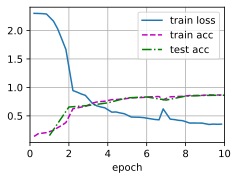

In [11]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = mxd2l.load_data_fashion_mnist(batch_size, resize=96)
mxd2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

## Torch

In [9]:
from torch import nn
from torch.nn import functional as F
class InceptionTC(nn.Module):
    def __init__(self,num_in_channels,c1:int,c2:tuple,c3:tuple,c4:int, **kwargs):
        super().__init__(**kwargs)
        
        #path1
        self.p1=nn.Conv2d(num_in_channels,c1,kernel_size=1)
        #path2
        self.p2_l1=nn.Conv2d(num_in_channels,c2[0],kernel_size=1)
        self.p2_l2=nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1)
        #path3
        self.p3_l1=nn.Conv2d(num_in_channels,c3[0],kernel_size=1)
        self.p3_l2=nn.Conv2d(c3[0],c3[1],kernel_size=5,padding=2)
        #path3
        self.p4_l1=nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.p4_l2=nn.Conv2d(num_in_channels,c4,kernel_size=1)
    def forward(self,X):
        y1=F.relu(self.p1(X))
        y2=F.relu(self.p2_l2(F.relu(self.p2_l1(X))))
        y3=F.relu(self.p3_l2(F.relu(self.p3_l1(X))))
        y4=F.relu(self.p4_l2(self.p4_l1(X)))
        y=tc.cat((y1,y2,y3,y4),dim=1)
        return y

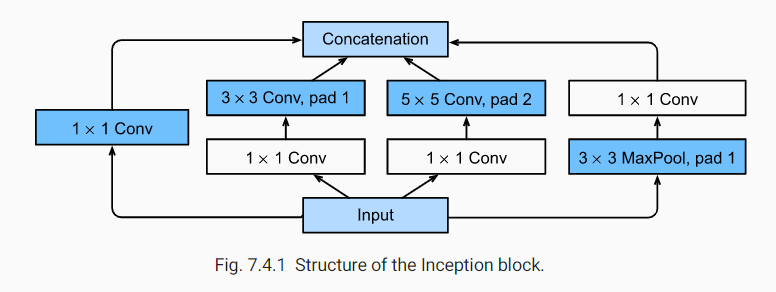

In [11]:
inceptiontc=InceptionTC(1,1,(1,2),(1,3),4)
inceptiontc

InceptionTC(
  (p1): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (p2_l1): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (p2_l2): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (p3_l1): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (p3_l2): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (p4_l1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (p4_l2): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 1))
)

In [12]:
X = tc.rand(size=(1, 1, 96, 96))
y=inceptiontc(X)
y.shape

torch.Size([1, 10, 96, 96])

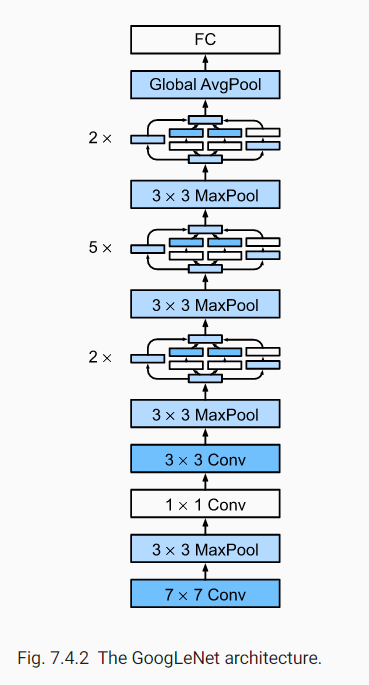

In [19]:
64+128+32+32,128+192+96+64

(256, 480)

In [23]:
X = tc.rand(size=(1, 1, 96, 96))
print("输入：",X.shape)
b1=nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3,stride=2,padding=1))
X=b1(X)
print("b1输出：",X.shape)
b2=nn.Sequential(nn.Conv2d(64,64,kernel_size=1),
                nn.ReLU(),
                nn.Conv2d(64, 192, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
X=b2(X)
print("b2输出：",X.shape)
b3=nn.Sequential(InceptionTC(192,64,(96,128),(16,32),32),
                InceptionTC(256,128,(128,192),(32,96),64),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
X=b3(X)
print("b3输出：",(128+192+96+64),X.shape)
b4 = nn.Sequential(InceptionTC(480, 192, (96, 208), (16, 48), 64),
                   InceptionTC(512, 160, (112, 224), (24, 64), 64),
                   InceptionTC(512, 128, (128, 256), (24, 64), 64),
                   InceptionTC(512, 112, (144, 288), (32, 64), 64),
                   InceptionTC(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
X=b4(X)
print("b4输出：",(256+320+128+128),X.shape)
b5 = nn.Sequential(InceptionTC(832, 256, (160, 320), (32, 128), 128),
                   InceptionTC(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveMaxPool2d((1,1)),
                   nn.Flatten())
X=b5(X)
print("b5输出：",X.shape)
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

输入： torch.Size([1, 1, 96, 96])
b1输出： torch.Size([1, 64, 24, 24])
b2输出： torch.Size([1, 192, 12, 12])
b3输出： 480 torch.Size([1, 480, 6, 6])
b4输出： 832 torch.Size([1, 832, 3, 3])
b5输出： torch.Size([1, 1024])


In [25]:
X = tc.rand(size=(1, 1, 96, 96))
print("输入：",X.shape)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

输入： torch.Size([1, 1, 96, 96])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


loss 0.303, train acc 0.885, test acc 0.865
1565.3 examples/sec on cuda:0


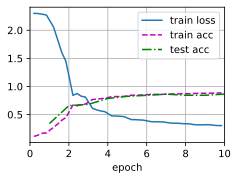

In [26]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = tcd2l.load_data_fashion_mnist(batch_size, resize=96)
tcd2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

## Tensorflow

In [2]:
from tensorflow import keras as K

In [3]:
class InceptionTF(K.Model):
    def __init__(self,c1,c2,c3,c4):
        super().__init__()
        self.p1=K.layers.Conv2D(c1,kernel_size=1,activation='relu')
        
        self.p2_l1=K.layers.Conv2D(c2[0],kernel_size=1,activation='relu')
        self.p2_l2=K.layers.Conv2D(c2[1],kernel_size=3,padding='same',activation='relu')
        
        self.p3_l1=K.layers.Conv2D(c3[0],kernel_size=1,activation='relu')
        self.p3_l2=K.layers.Conv2D(c3[1],kernel_size=5,padding='same',activation='relu')
        
        self.p4_l1=K.layers.MaxPool2D(pool_size=3,strides=1,padding='same')
        self.p4_l2=K.layers.Conv2D(c4,kernel_size=1,activation='relu')
    def call(self,x):
        y1=self.p1(x)
        y2=self.p2_l2(self.p2_l1(x))
        y3=self.p3_l2(self.p3_l1(x))
        y4=self.p4_l2(self.p4_l1(x))
        y=tf.concat([y1,y2,y3,y4],axis=-1)
        return y


In [4]:
X = tf.random.uniform(shape=(1, 96, 96, 1))
incep=InceptionTF(1,(1,2),(1,3),4)
y=incep(X)
y.shape

TensorShape([1, 96, 96, 10])

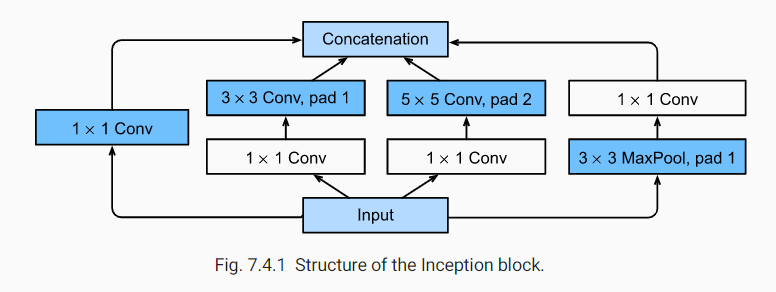

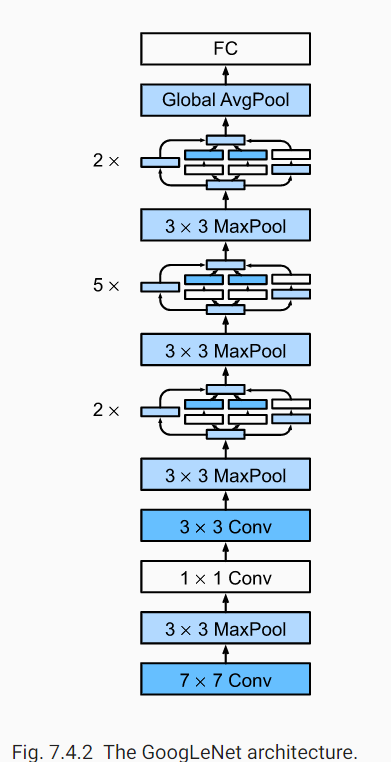

In [5]:
def net():
    b1=K.models.Sequential([
        K.layers.Conv2D(64, 7, strides=2, padding='same',activation='relu'),
        K.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
    ])
    
    b2=K.models.Sequential([
        K.layers.Conv2D(64, 1, activation='relu'),
        K.layers.Conv2D(192, 3, padding='same',activation='relu'),
        K.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
    ])
    
    b3=K.models.Sequential([
        InceptionTF(64, (96, 128), (16, 32), 32),
        InceptionTF(128, (128, 192), (32, 96), 64),
        K.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
    ])
    
    b4=K.models.Sequential([
        InceptionTF(192, (96, 208), (16, 48), 64),
        InceptionTF(160, (112, 224), (24, 64), 64),
        InceptionTF(128, (128, 256), (24, 64), 64),
        InceptionTF(112, (144, 288), (32, 64), 64),
        InceptionTF(256, (160, 320), (32, 128), 128),
        K.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
    ])
    
    b5=K.models.Sequential([
        InceptionTF(256, (160, 320), (32, 128), 128),
        InceptionTF(384, (192, 384), (48, 128), 128),
        K.layers.GlobalAvgPool2D(),
        K.layers.Flatten()
    ])
    
    net=K.models.Sequential([b1,b2,b3,b4,b5,K.layers.Dense(10)])
    return net

In [6]:
net_tf=net()

In [7]:
net_tf.layers

In [8]:
X = tf.random.uniform(shape=(1, 96, 96, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 (1, 24, 24, 64)
Sequential output shape:	 (1, 12, 12, 192)
Sequential output shape:	 (1, 6, 6, 480)
Sequential output shape:	 (1, 3, 3, 832)
Sequential output shape:	 (1, 1024)
Dense output shape:	 (1, 10)


loss 0.249, train acc 0.906, test acc 0.901
1600.1 examples/sec on /GPU:0


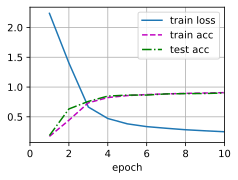

In [9]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = tfd2l.load_data_fashion_mnist(batch_size, resize=96)
tfd2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)